In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.stats import gamma, multivariate_normal

from gproc.elliptic import ess_samples_probit
from gproc.generative import sample_at_x
from gproc.kernels import *
from gproc.laplace import laplace_approximation_probit
from gproc.approx_marginal_is import importance_sampler

from gproc.metropolis_hastings import mh1

In [28]:
JITTER = 1e-5

In [29]:
N = 50 # Data size
D = 1 # Data dimension

x = np.random.normal(0, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
y, prob_y, f = sample_at_x(x, kernel_fcn = periodic, kernel_params = {'lengthscale': 1, 'variance': 1, 'period':1})

th_0 = np.array([1, 1, 1])
gram = periodic(x, x, lengthscale = th_0[0], variance = th_0[1], period = th_0[2])
inverse_gram = chol_inverse(gram)

In [30]:
# Get approximation to latent function posterior
laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)

print(f'Converged: {converged}')

marg_0 = importance_sampler(y, x, laplace_mean, laplace_cov, 100)
marg_0

Converged: True


-182521.02832220745

In [31]:
def mh_step(y, x, Kernel, marg_old, cov, N_imp = 100):
    """
    Performs one transition of the Pseudo-Marginal Metropolis Hastings algorithm.

    Parameters
    ----------
    y: N dimensional numpy vector
        responses
    
    x: N x D dimensional numpy array
        covariates
        
    Kernel: class
        kernel generating class

    th_old: numpy vector
        contains old kernel parameters

    marg_old: float
        contains old approximation of the marginal
        
    cov: numpy array
        covariance matrix for use in the proposal distribution
        
    N_imp: float
        Number of importance samples to use in marginal approximation

    Returns
    ----------
    th_new: numpy vector
        new sample kernel parameters
    
    marg_new: float
        new marginal approximation
    
    move: boolean
        flag indicating whether or not we moved
    """    
    # Get the current unconstrained kernel parameters
    th_old = Kernel.get_params()
    
    # Generate new unconstrained Kernel parameters from the proposal distribution
    th_new = np.random.multivariate_normal(th_old, cov, 1)[0]
    
    # Constrain the new parameters and update the kernel with them
    Kernel.constrain_params(th_new) 
    Kernel.update_params(Kernel.constrained_params)
                             
    # Create the new kernel gram matrix, and make new Laplace approximation
    gram = Kernel.make_gram(x, x)
    inverse_gram = Kernel.invert_gram()
    laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)
    
    # Compute new marginal approximation
    marg_new = importance_sampler(y, x, laplace_mean, laplace_cov, N_imp)
    
    # Compute MH log ratio
    # Dimension of covariates for Gamma prior hyperameters in MH ratio
    d = x.shape[1]
    numer = marg_new +  Kernel.prior_log_pdf(th_new, d) + multivariate_normal.logpdf(th_old, mean = th_new)
    denom = marg_old +  Kernel.prior_log_pdf(th_old, d) + multivariate_normal.logpdf(th_new, mean = th_old)
    logratio = numer - denom
    
    # Check if we should move
    move = False
    u = np.random.uniform(0, 1, 1)
    if logratio > np.log(u):
        move = True
        # Remember to update the Kernel with the new unconstrained parameters
        Kernel.update_params(th_new)
        return Kernel, th_new, marg_new, move
    else:
        # Remember to update the Kernel with the old unconstrained parameters
        Kernel.update_params(th_old)
        return Kernel, th_old, marg_old, move
        

In [32]:
Kernel = Periodic(lengthscale = th_0[0], variance = th_0[1], period = th_0[2])

In [33]:
mh_step(y, x, Kernel, marg_0, cov = 0.5*np.eye(Kernel.param_dim), N_imp = 100)

(<gproc.kernels.Periodic at 0x7ffa702429a0>,
 array([1.0067055 , 0.02485218, 0.19190894]),
 -39375.11680651361,
 True)

In [34]:
def mh(iters, y, x, Kernel, marg_0, cov, N_imp = 100, verbose = False):
    """
    Function that generates samples from the posterior distribution over
    kernel parameters.

    Parameters
    ----------
    iters: float
        number of iterations of the Metropolis Hastings algorithm
        
    y: N dimensional numpy vector
        responses
    
    x: N x D dimensional numpy array
        covariates
        
    Kernel: class
        kernel generating class

    th_0: numpy vector
        initial kernel parameters

    marg_0: float
        initial approximation of the marginal
        
    cov: numpy array
        covariance matrix for use in the proposal distribution
        
    N_imp: float
        number of importance samples to use in marginal approximation
    
    verbose: boolean
        flag to produce loading bar

    Returns
    ----------
    th_arr: numpy array
        contains the chains move history
    
    marg_arr: numpy array
        contains the history of marginal approximations
    
    acc_rate: float
        acceptance rate of moves
    """
    
    # Create array to hold samples and move history
    th_arr = np.zeros((iters + 1, th_0.shape[0]))
    marg_arr = np.zeros(iters + 1)
    move_arr = np.zeros(iters)
    
    # Add initialisation
    th_arr[0, :] = th_0
    marg_arr[0] = marg_0
    
    for i in tqdm(range(iters), disable=not(verbose)):
        Kernel, th_arr[i + 1, :], marg_arr[i + 1], move_arr[i] = mh_step(y, x, Kernel, marg_arr[i], cov = cov, N_imp = N_imp)
    
    acc_rate = move_arr.mean()
    return th_arr, marg_arr, acc_rate
    
    

In [55]:
th_0 = np.array([1, 1, 1])

Kernel = Periodic(lengthscale = th_0[0], variance = th_0[1], period = th_0[2])

th_arr, marg_arr, acc_rate = mh(10000, y, x, Kernel, marg_0, cov = 0.02*np.eye(th_0.shape[0]), N_imp = 64, verbose = True)

  0%|          | 0/10000 [00:00<?, ?it/s]

24.560000000000002


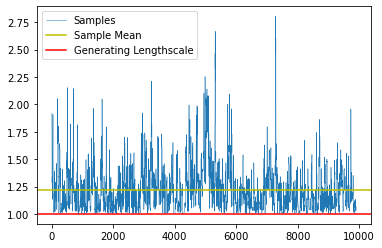

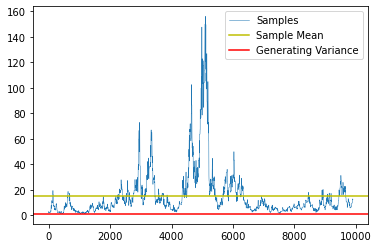

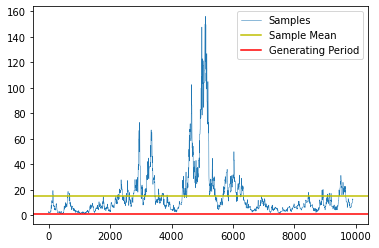

In [56]:
print(acc_rate*100)
burn_in = 100

plt.plot(np.exp(th_arr[burn_in:, 0]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[burn_in:, 0])), c = 'y', label = 'Sample Mean')
plt.axhline(y = 1, label = 'Generating Lengthscale', c = 'r')
plt.legend()
plt.show()

plt.plot(np.exp(th_arr[burn_in:, 1]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[burn_in:, 1])), c = 'y', label = 'Sample Mean')
plt.axhline(y = 1, label = 'Generating Variance', c = 'r')
plt.legend()
plt.show()

plt.plot(np.exp(th_arr[burn_in:, 1]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[burn_in:, 1])), c = 'y', label = 'Sample Mean')
plt.axhline(y = 1, label = 'Generating Period', c = 'r')
plt.legend()
plt.show()

In [ ]:
th_arr, marg_arr, acc_rate = mh1(10000, y, x, th_0, marg_0, cov = 0.1*np.eye(th_0.shape[0]), N_imp = 64, verbose = True)

22.42


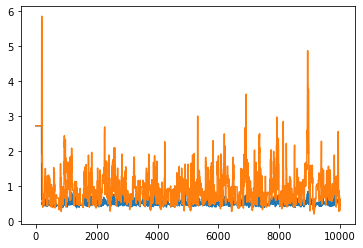

In [36]:
print(acc_rate*100)

plt.plot(np.exp(th_arr[burn_in:, 0]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[burn_in:, 0])), c = 'y', label = 'Sample Mean')
plt.axhline(y = 1, label = 'Generating Lengthscale', c = 'r')
plt.legend()
plt.show()

plt.plot(np.exp(th_arr[burn_in:, 1]), label = 'Samples', linewidth = 0.5)
plt.axhline(y = np.mean(np.exp(th_arr[burn_in:, 1])), c = 'y', label = 'Sample Mean')
plt.axhline(y = 1, label = 'Generating Variance', c = 'r')
plt.legend()
plt.show()